<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/EXPERIMENT_1_CNN_Transfer_Learning_W207_Fall2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#W207 Applied Machine Learning
**Fall 2022**<br>
Heesuk Jang

# CNN With Transfer Learning - With Unfrozen Last Layer of Pre-Trained Models

## Machine Learning Pipepline

  1) EDA and Image Visualization<br>
> On the original entire dataset<br>
> On the 1200 sample dataset: randomly sample from training/test/validation = 800/ 200/ 200 (67%/ 17%/ 17%%)

  2) Image Augmentations<br>
> Adjust brightness<br>
> Adjust contrast<br>
> Horizontal flip<br>
> Vertical flip<br>
> Random rotate<br>
> Rotate 90 degrees counter clockwise<br>
> Rotate 90 degrees clockwise<br>
> Randome zoom-in<br>
> Fillmode nearest<br>
> Shift images right-up<br>
> Shift images left-down<br>

3) Image Normalization to [0, 1]<br>
4) Employ Transfer Learning Models<br>
> VGG16<br>
> ResNet50<br>
> VGG19<br>
> DenseNet201<br>
> ResNet152V2<br>

 5) Define a Custom CNN Model While Defining Hyperparameters<br>

6) Utilize Keras RandomSearch Tuner to Tune the Following Hyperparameters and Find the Best Hyperparameters<br>
> Optimizer<br>
> Activation<br>
> Dense Units<br>
> Learning Rate<br>
> Dropout ratio<br>
> Binary (True or False): Add Dense Layer?<br>
> Brightness Delta<br>
> Contrast Factor<br>
> Rotate Angle<br>
> Shift Width and Height<br>

 7) Define the Top Model Using the Best Hpyerparameters <br>
> Build model<br>
> Compile model<br>

 8) Predict and Evaluate the Model (True Labels VS. Predicted Labels)<br>
> Accuracy: Training/Test/Validation<br>
> Confusion Matrix<br>
> Recall, Precision, F1 Score<br>
> ROC-AUC Score and Area Under the ROC Curve<br>
> Zero One Loss<br>
> Number of Trainable Parameters<br>

 9) Run Experiments<br>
> Top Model with VGG16<br>
> Top Model with ResNet50<br>
> Top Model with VGG19<br>
> Top Model with DenseNet201<br>
> Top Model with ResNet152V2<br>




In [13]:
import pandas as pd
import numpy as np
import os
import time
import random
import joblib
import glob
import random
from itertools import product
import gc
import subprocess
import shutil
import copy
import statistics as st
from scipy import stats
from google.colab import files

from imutils import rotate as rotate
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Concatenate

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, cohen_kappa_score, zero_one_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
#from livelossplot import PlotLossesKeras

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
# from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import PReLU, ReLU, LeakyReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D 
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from tensorflow.keras.models import Sequential

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from tensorflow.keras.applications import ResNet152V2
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import *


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, save_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from IPython.display import Image
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=DeprecationWarning)

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
import logging

# get TF logger
log = logging.getLogger('tensorflow') # tell it to log it to a file

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load the entire data as a zip directly from Kaggle and unzip

In [14]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [15]:
%ls

10253/  10305/  12881/  13018/  14153/  16085/  8980/  9255/
10254/  10306/  12882/  13019/  14154/  16165/  8984/  9256/
10255/  10307/  12883/  13020/  14155/  16166/  9022/  9257/
10256/  10308/  12884/  13021/  14156/  16167/  9023/  9258/
10257/  12241/  12886/  13022/  14157/  16531/  9029/  9259/
10258/  12242/  12890/  13023/  14188/  16532/  9035/  9260/
10259/  12626/  12891/  13024/  14189/  16533/  9036/  9261/
10260/  12748/  12892/  13025/  14190/  16534/  9037/  9262/
10261/  12749/  12893/  13106/  14191/  16550/  9041/  9265/
10262/  12750/  12894/  13400/  14192/  16551/  9043/  9266/
10264/  12751/  12895/  13401/  14209/  16552/  9044/  9267/
10268/  12752/  12896/  13402/  14210/  16553/  9073/  9290/
10269/  12810/  12897/  13403/  14211/  16554/  9075/  9291/
10272/  12811/  12898/  13404/  14212/  16555/  9076/  9319/
10273/  12817/  12900/  13458/  14213/  16568/  9077/  9320/
10274/  12818/  12901/  13459/  14304/  16569/  9078/  9321/
10275/  12819/  12905/  

# Read image files from IDC_regular_ps50_idx5 folder where contains 50 by 50 images

In [16]:
def read_image_files(binary_class):
  current_working_dir = os.getcwd()
  folder = 'IDC_regular_ps50_idx5/*/'

  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path)    
  return image_files_wo_path, image_files_w_path

class_1_malignant_wo_path, class_1_malignant_w_path = read_image_files('1')
class_0_benign_wo_path, class_0_benign_w_path = read_image_files('0')
full_data_wo_path = class_1_malignant_wo_path + class_0_benign_wo_path
full_data_w_path = class_1_malignant_w_path + class_0_benign_w_path

# Check the number of image files in each class

In [44]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count = ', class_1_size + class_0_size)
  return df_perc

df_full_org_per = check_class_size(class_1_malignant_wo_path, class_0_benign_wo_path)

Total Count =  277524


# Create dataframes for each class

In [42]:
def create_class_df(class_1_w_path, class_0_w_path): 
  image_list_w_path = [x for x in class_1_w_path]
  image_list_w_path.extend([x for x in class_0_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_w_path), ['Non_IDC']*len(class_0_w_path)]), columns=['class_str'])
  df_idc['class'] = np.where(df_idc.class_str == 'IDC', 1, 0)
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc
  
df_full_org = create_class_df(class_1_malignant_w_path, class_0_benign_w_path)
df_full_org

Shape:  (277524, 3)


,class_str,class,image
0,IDC,1,/content/IDC_regular_ps50_idx5/9290/1/9290_idx...
1,IDC,1,/content/IDC_regular_ps50_idx5/9290/1/9290_idx...
2,IDC,1,/content/IDC_regular_ps50_idx5/9290/1/9290_idx...
3,IDC,1,/content/IDC_regular_ps50_idx5/9290/1/9290_idx...
4,IDC,1,/content/IDC_regular_ps50_idx5/9290/1/9290_idx...
...,...,...,...
277519,Non_IDC,0,/content/IDC_regular_ps50_idx5/13613/0/13613_i...
277520,Non_IDC,0,/content/IDC_regular_ps50_idx5/13613/0/13613_i...
277521,Non_IDC,0,/content/IDC_regular_ps50_idx5/13613/0/13613_i...
277522,Non_IDC,0,/content/IDC_regular_ps50_idx5/13613/0/13613_i...


# Plot counterplot for the entire dataset

,class,class_count,class_percent(%)
0,Class 1 (Malignant),78786,28.39
1,Class 0 (Benign),198738,71.61


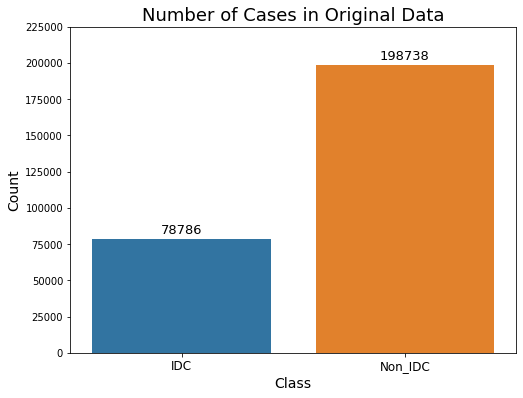

In [45]:
def counterplot(df, ylim, substr):
  plt.figure(figsize=(8,6))
  ax = sns.countplot(df['class_str'], data=df)
  plt.xlabel('Class', fontsize=14)
  plt.ylabel('Count', fontsize=14)
  plt.xticks(fontsize=12)
  plt.title(f'Number of Cases in {substr}', fontsize=18)
  plt.ylim(0,ylim)
  for p in ax.patches:
      ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2., 
                  p.get_height()), ha='center', va='center', size=15, xytext=(0,9),
                textcoords = 'offset points', fontsize=13)
counterplot(df_full_org, 225000, 'Original Data')
df_full_org_per

# Install Keras Tuner

In [4]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 135 kB 30.9 MB/s 
     |████████████████████████████████| 1.6 MB 54.9 MB/s 


# Unzip the zip with 1200 samples
- Training/Test/Validate = 800/200/200

In [5]:
!unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip                  

Archive:  gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip
   creating: Dataset/
   creating: Dataset/Validate/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/Test/
   creating: Dataset/Train/
  inflating: Dataset/Validate/.DS_Store  
  inflating: __MACOSX/Dataset/Validate/._.DS_Store  
   creating: Dataset/Validate/0/
   creating: Dataset/Validate/1/
  inflating: Dataset/Test/.DS_Store  
  inflating: __MACOSX/Dataset/Test/._.DS_Store  
   creating: Dataset/Test/0/
   creating: Dataset/Test/1/
  inflating: Dataset/Train/.DS_Store  
  inflating: __MACOSX/Dataset/Train/._.DS_Store  
   creating: Dataset/Train/0/
   creating: Dataset/Train/1/
  inflating: Dataset/Validate/0/12867_idx5_x651_y1801_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._12867_idx5_x651_y1801_class0.png  
  inflating: Dataset/Validate/0/16165_idx5_x3001_y1551_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._16165_idx5_x3001_y1551_class0.png  
  inflating

# Check on the count of image files

In [6]:
# Delete a full folder including all its files and subfolders if exists
!rm -rf processed_images/   

# Check the dataset and count of files
!ls -ltr Dataset  
!ls -ltr Dataset/Train/0|wc -l
!ls -ltr Dataset/Train/1|wc -l

!ls -ltr Dataset/Test/0|wc -l
!ls -ltr Dataset/Test/1|wc -l

!ls -ltr Dataset/Validate/0|wc -l
!ls -ltr Dataset/Validate/1|wc -l          

total 12
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Test
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Train
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Validate
401
401
101
101
101
101


# Remove unnecessary files from the folder that contains the original images

In [7]:
# Folder paths for the raw dataset
val_image_directory = '/content/Dataset/Validate'
train_image_directory = '/content/Dataset/Train'
test_image_directory = '/content/Dataset/Test'
directory_path = '/content/Dataset'

In [22]:
def preprocess(data_dir):
  ''' 
  Remove .DS_Store files from each sub-folders
  '''

  images_path_1 = [data_dir + '/' +  dir + '/' for dir in os.listdir(data_dir) if dir != '.DS_Store'][1]      
  images_path_0 = [data_dir + '/' +  dir + '/' for dir in os.listdir(data_dir) if dir != '.DS_Store'][0]
  images_list_1 = [images_path_1 + file for file in list(os.walk(images_path_1))[0][2] if file[0] != '.']
  images_list_0 = [images_path_0 + file for file in list(os.walk(images_path_0))[0][2] if file[0] != '.']
  return images_list_1, images_list_0

In [23]:
train_1_images_list, train_0_images_list = preprocess(train_image_directory)
test_1_images_list, test_0_images_list = preprocess(test_image_directory)
val_1_images_list, val_0_images_list = preprocess(val_image_directory)

# Re-check the count of PNG files

In [24]:
print('Count of the entire samples: ', len(train_1_images_list + train_0_images_list + test_1_images_list + test_0_images_list + val_1_images_list + val_0_images_list))
print(f'Length of train 1: {len(train_1_images_list)} \nLength of train 0: {len(train_0_images_list)} \nLength of test 1: {len(test_1_images_list)} \nLength of test 0: {len(test_0_images_list)} \nLength of val 1: {len(val_1_images_list)} \nLength of val 0: {len(val_0_images_list)}')

Count of the entire samples:  1200
Length of train 1: 400 
Length of train 0: 400 
Length of test 1: 100 
Length of test 0: 100 
Length of val 1: 100 
Length of val 0: 100


# Create dataframes for each class in samples

In [25]:
full_data_malignant_1 = train_1_images_list + test_1_images_list + val_1_images_list
full_data_benign_0 = train_0_images_list + test_0_images_list + val_0_images_list

df_full_sample = create_class_df(full_data_malignant_1, full_data_benign_0)
df_full_sample  

Shape:  (1200, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Train/0/9322_idx5_x1651_y301_...
1,IDC,1,/content/Dataset/Train/0/14305_idx5_x2201_y551...
2,IDC,1,/content/Dataset/Train/0/10288_idx5_x2101_y210...
3,IDC,1,/content/Dataset/Train/0/9259_idx5_x3051_y2151...
4,IDC,1,/content/Dataset/Train/0/8867_idx5_x1401_y1801...
...,...,...,...
1195,Non_IDC,0,/content/Dataset/Validate/1/13459_idx5_x1001_y...
1196,Non_IDC,0,/content/Dataset/Validate/1/12932_idx5_x1501_y...
1197,Non_IDC,0,/content/Dataset/Validate/1/16014_idx5_x801_y6...
1198,Non_IDC,0,/content/Dataset/Validate/1/9081_idx5_x2501_y1...


# Plot counterplot for the sample data

Total Count =  1200


,class,class_count,class_percent(%)
0,Class 1 (Malignant),600,50.0
1,Class 0 (Benign),600,50.0


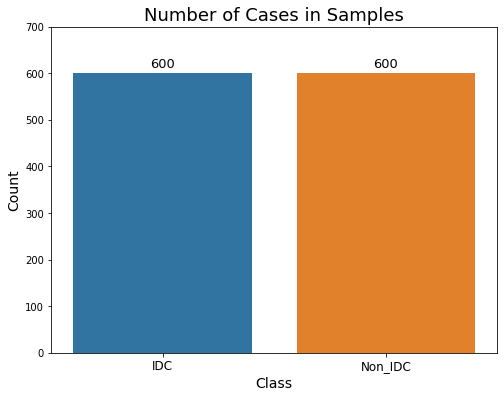

In [47]:
df_full_sample_per = check_class_size(full_data_malignant_1, full_data_benign_0)
counterplot(df_full_sample, 700,  'Samples')
df_full_sample_per

# Display the first 6 images for each class
IDC Malignant (1) vs. IDC Benign (0)


In [ ]:
IMG_SIZE = 50

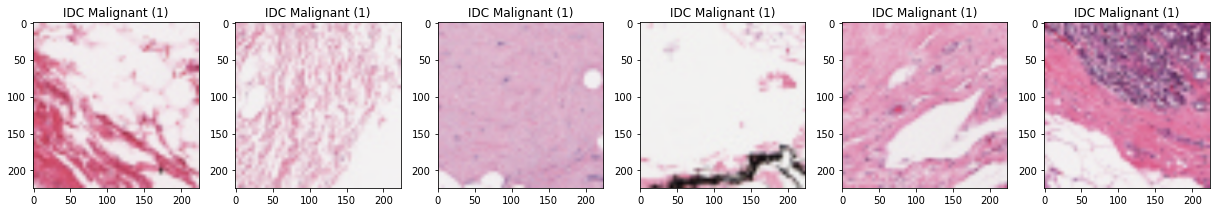

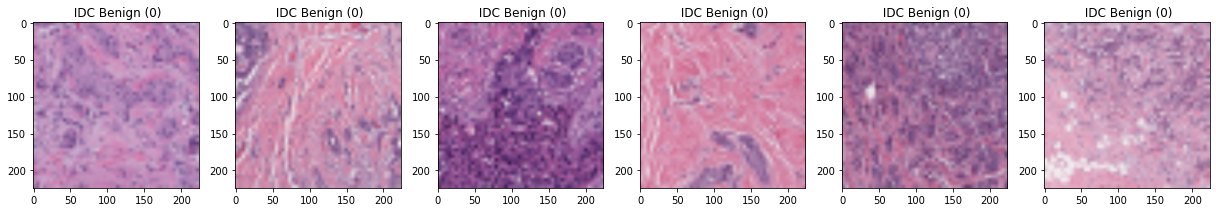

In [ ]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    # ax.set_xticks([])       # remove xticks passing an empty array
    # ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_1_images_list, 'IDC Malignant (1)')
display_images(train_0_images_list, ' IDC Benign (0)')

# Check the image dimension in different color scale
- RGB with 3-channels
- Grayscale with 1-channel

Grayscale image shape:  (50, 50, 1)
RGB image shape:  (50, 50, 3)


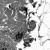

In [19]:
# Grayscale
test_img = load_img(train_1_images_list[0], color_mode ="grayscale")
test_img_arry = img_to_array(test_img)/255                                 # normalize
print('Grayscale image shape: ',test_img_arry.shape)

# RGB
test_img1 = load_img(train_1_images_list[0])
test_img1_arry = img_to_array(test_img1)
print('RGB image shape: ',test_img1_arry.shape)

array_to_img(test_img_arry)

# Filter out odd images
- Exclude images that are NOT **50 by 50**
- Exclude images without **.png** extension

In [23]:
odd_images = []
def extract_odd_images(file_list, IMG_SIZE = 50):
    for file_name in file_list:
        test_img = load_img(file_name, color_mode ="grayscale")
        test_img_arry = img_to_array(test_img)
        if test_img_arry.shape[0] != IMG_SIZE or test_img_arry.shape[1] != IMG_SIZE:       # if width != 50 or height != 50
            odd_images.append(file_name)

In [24]:
extract_odd_images(train_1_images_list + train_0_images_list + test_1_images_list + test_0_images_list + val_1_images_list + val_0_images_list)

In [32]:
print(f'Number of Bad Images: ', len(odd_images),'\n')
odd_images

Number of Bad Images:  7 



['/content/Dataset/Train/0/12954_idx5_x1651_y2951_class0.png',
 '/content/Dataset/Train/0/13106_idx5_x1_y2951_class0.png',
 '/content/Dataset/Train/0/9347_idx5_x2101_y801_class0.png',
 '/content/Dataset/Test/0/13404_idx5_x1101_y2901_class0.png',
 '/content/Dataset/Validate/0/12931_idx5_x1901_y2151_class0.png',
 '/content/Dataset/Validate/0/13694_idx5_x1551_y2801_class0.png',
 '/content/Dataset/Validate/0/9320_idx5_x801_y2951_class0.png']

# Display the 7 bad images
- 3 images from training set
- 3 images from validation set
- 1 image from test set

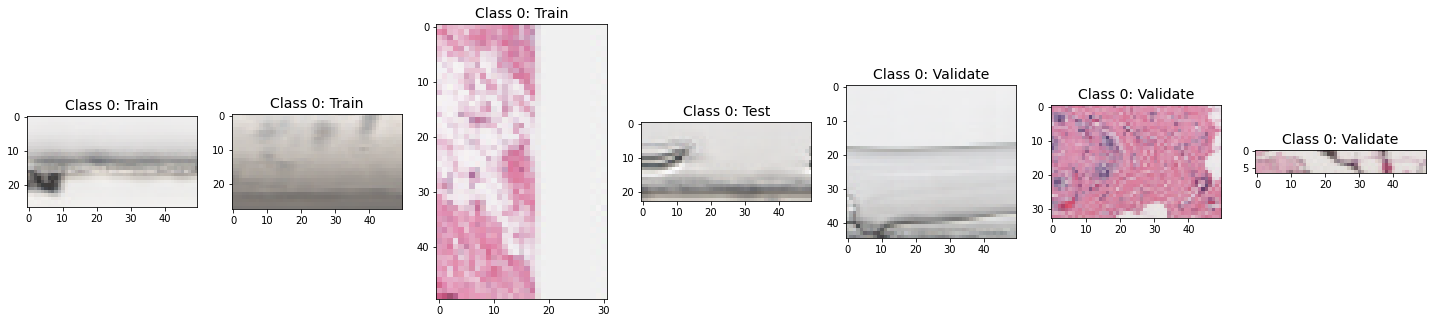

In [26]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass[idx])
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass[idx].split('/')[3]
    img = io.imread(subclass[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print();display_images(odd_images)

# Create new directory paths to store processed images


In [34]:

# Define the folder paths where the processed images will be stored
dest_directory_path = '/content/processed_images'
dest_train_1_image_path = '/content/processed_images/train/1/'
dest_train_0_image_path = '/content/processed_images/train/0/'
dest_val_1_image_path = '/content/processed_images/val/1/'
dest_val_0_image_path = '/content/processed_images/val/0/'
dest_test_1_image_path = '/content/processed_images/test/1/'
dest_test_0_image_path = '/content/processed_images/test/0/'

lst_target_folder_path = [dest_train_1_image_path, dest_train_0_image_path,
                 dest_val_1_image_path, dest_val_0_image_path,
                 dest_test_1_image_path, dest_test_0_image_path
                ]

In [35]:
root_dir = 'processed_images'

os.makedirs(f'{root_dir}', exist_ok = True)
for dir in ['train', 'val', 'test']:
    for sub_dir in ['1', '0']:
        os.makedirs(f'{root_dir}/{dir}/{sub_dir}', exist_ok=True)

# Display images with each effect of augmentation technique


  Original:50x50(RGB)



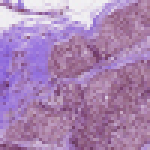


 Not normalized-Original:50x50(Gray)



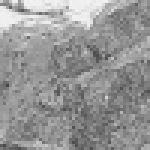


Normalized-gray



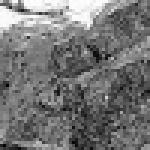


 Brightness:0.1,0.3



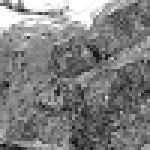


    Contrast:1,3



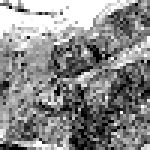


  Horizontal Flip



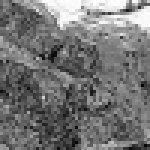


   Vertical Flip



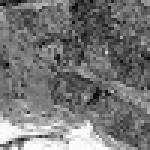


    RandomRotate



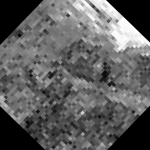


    Rotate 90:CCW



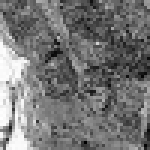


     Rotate 90:CW



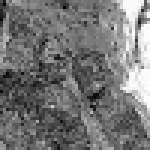


 RandomShift:LeftDown



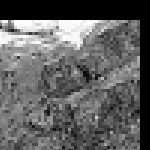


 RandomShift:RightUp



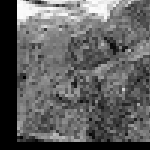

In [36]:
# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

from google.colab.patches import cv2_imshow
target_size=(150,150)

# original: 50x50 rgb 
org_img = load_img(train_0_images_list[2], color_mode ="rgb", target_size=target_size)
org_img_arry = img_to_array(org_img)
print("  Original:50x50(RGB)");print()
cv2_imshow(org_img_arry)

# original: 50x50 grayscale 
test_img = load_img(train_0_images_list[2], color_mode ="grayscale", target_size=target_size)
test_img_arry = img_to_array(test_img)
print();print(" Not normalized-Original:50x50(Gray)");print()
cv2_imshow(test_img_arry)

#  normalized gray scale
norm_test_img_arry = cv2.normalize(test_img_arry, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print();print('Normalized-gray');print()
cv2_imshow(norm_test_img_arry)
# print('norm1-gray:\n', norm_test_img_arry)

# brightness
bright_img_gs = tf.image.adjust_brightness(norm_test_img_arry, delta=10)
bright_img_gs = img_to_array(bright_img_gs)
print();print(" Brightness:0.1,0.3");print()
cv2_imshow(bright_img_gs)

# contrast
contrast_img_gs = tf.image.adjust_contrast(test_img_arry, contrast_factor=3)
contrast_img_gs = img_to_array(contrast_img_gs)
print();print("    Contrast:1,3");print()
cv2_imshow(contrast_img_gs)

# horizontal flip
hflip_img_gs = cv2.flip(norm_test_img_arry, 1)
print();print("  Horizontal Flip");print()
cv2_imshow(hflip_img_gs)

# vertical flip
vflip_img_gs = cv2.flip(norm_test_img_arry, 0)
print();print("   Vertical Flip");print()
cv2_imshow(vflip_img_gs)

# random rotate 
angle = int(random.uniform(-90, 90))
hr, wr = norm_test_img_arry.shape[:2]
M = cv2.getRotationMatrix2D((int(wr/2), int(hr/2)), angle, 1)
rotated_img_gs = cv2.warpAffine(norm_test_img_arry, M, (wr, hr))
rotated_img_gs = img_to_array(rotated_img_gs)
print();print("    RandomRotate");print()
cv2_imshow(rotated_img_gs)

# rotate 90 degree ccw
out=cv2.transpose(norm_test_img_arry)
out=cv2.flip(out,flipCode=0)
rotated_img_gs = img_to_array(out)
print();print("    Rotate 90:CCW");print()
cv2_imshow(out)

# rotate 90 degree cw
out=cv2.transpose(norm_test_img_arry)
out=cv2.flip(out,flipCode=1)
rotated_img_gs = img_to_array(out)/255        # normalize it after augment the image
# print('rotated_img_gs',rotated_img_gs)
print();print("     Rotate 90:CW");print()
cv2_imshow(out)

# shift the image 5 pixels to the left and 10 pixels down
M = np.float32([[1, 0, -10], [0, 1, 20]])
shifted_ld_gs = cv2.warpAffine(norm_test_img_arry, M, (norm_test_img_arry.shape[1], norm_test_img_arry.shape[0]))
print();print(" RandomShift:LeftDown");print()
cv2_imshow(shifted_ld_gs)

# shift the image 5 pixels to the right and 10 pixels up
M = np.float32([[1, 0, 17], [0, 1, -8]])
shifted_ru_gs = cv2.warpAffine(norm_test_img_arry, M, (norm_test_img_arry.shape[1], norm_test_img_arry.shape[0]))
print();print(" RandomShift:RightUp");print()
cv2_imshow(shifted_ru_gs)

# Image augmentation on training dataset

Images are already normalized in **ImageDataGenerator by rescaling 1.0/255** thus we DO NOT NEED to normalize images in this **augmentation_on_grayscale_grayscale()** function.

In [39]:
def augmentation_on_grayscale(file_list, dest_dir, data_class , brightness_delta=0.3, contrast_factor=3, angle=90, right=7, up=-10, left=-7, down=10):
  lst_train_1_gs, lst_train_0_gs = [], []
  lst_val_1_gs, lst_val_0_gs = [], []
  lst_test_1_gs, lst_test_0_gs = [], []

  file_extension = '.png'
  for image_file in file_list:
      if image_file[0] == '.' or image_file in odd_images:                                        # if image_file = .DS_Store or an odd image then ignore
          continue
      img_gs = load_img(image_file, color_mode = "grayscale")                                     # convert images from colorscale to grayscale
      img_array_gs = img_to_array(img_gs)                                                         # convert grayscale images to array
      
      file_name = image_file.split("/")[-1]                                                       # extract only filenames from the full file path
      save_img(dest_dir + file_name.split(".")[0] + '_gs' + file_extension, img_array_gs)         # save grayscale images to the processed_images folder

      # Fill mode - nearest
      def fill_mode(ratio, img):
        fm_ratio = random.uniform(-ratio, ratio)
        h, w = img.shape[:2]
        to_shift = int(w*fm_ratio)
        if fm_ratio > 0:
            img = img[:, :w-to_shift, :]
            nearest_img_gs = cv2.copyMakeBorder(img, 0, 0, to_shift, 0, cv2.BORDER_REPLICATE)
        if fm_ratio < 0:
            img = img[:, -1*to_shift:, :]
            nearest_img_gs = cv2.copyMakeBorder(img, 0, 0, 0, -1*to_shift, cv2.BORDER_REPLICATE)
        return nearest_img_gs

      # Random ZoomIn
      def zoom_in(ratio, img):
        z_ratio = random.uniform(ratio, 1)
        h, w = img.shape[:2]
        h_taken = int(z_ratio*h)
        w_taken = int(z_ratio*w)
        h_start = random.randint(0, h-h_taken)
        w_start = random.randint(0, w-w_taken)
        img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
        zoomed_img_gs = cv2.resize(img, (h, w), cv2.INTER_CUBIC)  
        return zoomed_img_gs

      if data_class == 1:
          # insert raw training images in gray scale
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)

          # adjust brightness
          bright_img_gs = tf.image.adjust_brightness(img_array_gs, delta=brightness_delta)
          img_array_bright_gs = img_to_array(bright_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension, img_array_bright_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension)
          
          # adjust contrast
          contrast_img_gs = tf.image.adjust_contrast(img_array_gs, contrast_factor=contrast_factor)
          img_array_contrast_gs = img_to_array(contrast_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension, img_array_contrast_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension)

          # horizontal flip
          hflip_img_gs = cv2.flip(img_array_gs, 1)
          img_array_hflip_gs = img_to_array(hflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension, img_array_hflip_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension)

          # vertical flip
          vflip_img_gs = cv2.flip(img_array_gs, 0)
          img_array_vflip_gs = img_to_array(vflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension, img_array_vflip_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension)

          # random rotate 
          rotate = int(random.uniform(-angle, angle))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), rotate, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension)
          
          # transpose and rotate 90 degrees counter clockwise (flip around x-axis)
          img_ccw90rot_gs = cv2.transpose(img_array_gs)
          img_ccw90rot_gs = cv2.flip(img_ccw90rot_gs, flipCode = 0)
          rotatedccw90_img_gs = img_to_array(img_ccw90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension, rotatedccw90_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension)
          #print("e")

          # transpose and rotate 90 degrees (flip around y-axis)
          img_90rot_gs = cv2.transpose(img_array_gs)
          img_90rot_gs = cv2.flip(img_90rot_gs, flipCode = 1)
          rotated90_img_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, rotated90_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          #print("f")

          # random zoom-in                       
          zoomed_img_gs = zoom_in(0.6, img_array_contrast_gs)
          img_array_zoomed_img_gs = img_to_array(zoomed_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_random_zoom_in_gs' + file_extension, img_array_zoomed_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_random_zoom_in_gs' + file_extension)

          # fill_mode = nearst
          nearest_img_gs = fill_mode(0.8, img_array_contrast_gs)
          img_array_nearest_img_gs = img_to_array(nearest_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_fillmode_nearest_gs' + file_extension, img_array_nearest_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_fillmode_nearest_gs' + file_extension)

          # shift the image 7 pixels to the right and -10 pixels up
          M = np.float32([[1, 0, right], [0, 1, up]])
          shifted_lu = cv2.warpAffine(img_array_gs, M, (img_array_gs.shape[1], img_array_gs.shape[0]))
          img_array_shifted_ru_gs = img_to_array(shifted_lu)
          save_img(dest_dir + file_name.split(".")[0] + '_shifted_right_up_gs' + file_extension, img_array_shifted_ru_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_shifted_right_up_gs' + file_extension)

          # # shift the image -7 pixels to the left and 10 pixels down
          M = np.float32([[1, 0, left], [0, 1, down]])
          shifted_rd = cv2.warpAffine(img_array_gs, M, (img_array_gs.shape[1], img_array_gs.shape[0]))
          img_array_shifted_ld_gs = img_to_array(shifted_rd)
          save_img(dest_dir + file_name.split(".")[0] + '_shifted_left_down_gs' + file_extension, img_array_shifted_ld_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_shifted_left_down_gs' + file_extension)

      elif data_class == 2:
          # insert raw training images in gray scale
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)

          # adjust brightness
          bright_img_gs = tf.image.adjust_brightness(img_array_gs, delta=brightness_delta)
          img_array_bright_gs = img_to_array(bright_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension, img_array_bright_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension)
          
          # adjust contrast
          contrast_img_gs = tf.image.adjust_contrast(img_array_gs, contrast_factor=contrast_factor)
          img_array_contrast_gs = img_to_array(contrast_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension, img_array_contrast_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension)

          # horizontal flip
          hflip_img_gs = cv2.flip(img_array_gs, 1)
          img_array_hflip_gs = img_to_array(hflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension, img_array_hflip_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension)

          # vertical flip
          vflip_img_gs = cv2.flip(img_array_gs, 0)
          img_array_vflip_gs = img_to_array(vflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension, img_array_vflip_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension)

          # rotate 90 degree
          rotate = int(random.uniform(-angle, angle))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), rotate, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension)
 
          # transpose and rotate 90 degrees counter clockwise (flip around x-axis)
          img_ccw90rot_gs = cv2.transpose(img_array_gs)
          img_ccw90rot_gs = cv2.flip(img_ccw90rot_gs, flipCode = 0)
          rotatedccw90_img_gs = img_to_array(img_ccw90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension, rotatedccw90_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension)

          # transpose and rotate 90 degrees (flip around y-axis)
          img_90rot_gs = cv2.transpose(img_array_gs)
          img_90rot_gs = cv2.flip(img_90rot_gs, flipCode = 1)
          rotated90_img_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, rotated90_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)

          # random zoom-in                       
          zoomed_img_gs = zoom_in(0.6, img_array_contrast_gs)
          img_array_zoomed_img_gs = img_to_array(zoomed_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_random_zoom_in_gs' + file_extension, img_array_zoomed_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_random_zoom_in_gs' + file_extension)

          # fill_mode = nearst
          nearest_img_gs = fill_mode(0.8, img_array_contrast_gs)
          img_array_nearest_img_gs = img_to_array(nearest_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_fillmode_nearest_gs' + file_extension, img_array_nearest_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_fillmode_nearest_gs' + file_extension)

          # shift the image 7 pixels to the right and -10 pixels up
          M = np.float32([[1, 0, right], [0, 1, up]])
          shifted_lu = cv2.warpAffine(img_array_gs, M, (img_array_gs.shape[1], img_array_gs.shape[0]))
          img_array_shifted_ru_gs = img_to_array(shifted_lu)
          save_img(dest_dir + file_name.split(".")[0] + '_shifted_right_up_gs' + file_extension, img_array_shifted_ru_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_shifted_right_up_gs' + file_extension)

          # # shift the image -7 pixels to the left and 10 pixels down
          M = np.float32([[1, 0, left], [0, 1, down]])
          shifted_rd = cv2.warpAffine(img_array_gs, M, (img_array_gs.shape[1], img_array_gs.shape[0]))
          img_array_shifted_ld_gs = img_to_array(shifted_rd)
          save_img(dest_dir + file_name.split(".")[0] + '_shifted_left_down_gs' + file_extension, img_array_shifted_ld_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_shifted_left_down_gs' + file_extension)

      elif data_class == 3:
          lst_val_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif data_class == 4:
          lst_val_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif data_class == 5:
          lst_test_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif data_class == 6:
          lst_test_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)              

# Store processed images to new directories

In [40]:
augmentation_on_grayscale(train_1_images_list, dest_train_1_image_path, 1, 0.3, 3, 45, 7, -10, -7, 10)
augmentation_on_grayscale(train_0_images_list, dest_train_0_image_path, 2, 0.3, 3, 45, 7, -10, -7, 10)
augmentation_on_grayscale(val_0_images_list, dest_val_0_image_path, 3, 0.3, 3, 45, 7, -10, -7, 10)
augmentation_on_grayscale(val_1_images_list, dest_val_1_image_path, 4, 0.3, 3, 45, 7, -10, -7, 10)
augmentation_on_grayscale(test_0_images_list, dest_test_0_image_path, 5, 0.3, 3, 45, 7, -10, -7, 10)
augmentation_on_grayscale(test_1_images_list, dest_test_1_image_path, 6, 0.3, 3, 45, 7, -10, -7, 10)

# Check the number of processed images in each class of training dataset
Increased the size of our dataset from 797 to 9,564, which is 12 times more to train.


In [41]:
!ls -ltra /content/processed_images/train/1/*.png|wc -l
!ls -ltra /content/processed_images/train/0/*.png|wc -l

4764
4800


# Define ImageDataGenerator 
- 1200 given raw images + augmented images<br>
- Normalize the pixels to the range of [0,1] using **rescale** in ImageDataGenerator

In [ ]:
batch_size = 64
random_state = 1234
image_size = 50

def data_generator(image_size): 
  processed_images_train_path = '/content/processed_images/train'                       # contains augmented images with original images 
  processed_images_validation_path = '/content/processed_images/val'
  processed_images_test_path = '/content/processed_images/test'

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)          # Normalize image pixels to the range of [0,1]
  train_data_generator = datagen.flow_from_directory(processed_images_train_path,
                                                                      target_size = (image_size, image_size),
                                                                      class_mode = 'categorical',
                                                                      batch_size = batch_size,
                                                                      color_mode = 'rgb',
                                                                      shuffle = True,
                                                                      seed = random_state
                                                                      )
  val_data_generator = datagen.flow_from_directory(processed_images_validation_path,
                                                                  target_size = (image_size, image_size),
                                                                  class_mode = 'categorical',
                                                                  batch_size = batch_size,
                                                                  color_mode = 'rgb',
                                                                  shuffle = True,
                                                                  seed = random_state
                                                                  )
  test_data_generator = datagen.flow_from_directory(processed_images_test_path,
                                                                    target_size = (image_size, image_size),
                                                                    batch_size = batch_size,
                                                                    class_mode = 'categorical',
                                                                    color_mode = 'rgb',
                                                                    shuffle = False,
                                                                    seed = random_state
                                                                    )
  return train_data_generator, val_data_generator, test_data_generator

# Define Transfer Learning Models

In [ ]:
def build_transfer_learning_model(chosen_model):
    """
    Utilizes transfer learning of a given custom model.
    """
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    tf.keras.backend.clear_session()

    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    if chosen_model == 'VGG19':
        model_tl = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'DenseNet201':
        model_tl = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'ResNet50':
        model_tl = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'ResNet152V2':
        model_tl = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = input_shape)       
    elif chosen_model == 'VGG16':
        model_tl = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'EfficientNetB7':
        model_tl = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'MobileNetV2':
        model_tl = MobileNetV2(weights='imagenet',include_top = False, input_shape=input_shape)
    elif chosen_model == 'Xception':
        model_tl = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'InceptionV3':
        model_tl = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
    return model_tl

# Define plot_model_accuracy_and_loss function

In [ ]:
def plot_model_accuracy_and_loss(history, chosen_model):
   """
   Plots model training and validation accuracy and loss.
   """
   tf.keras.backend.clear_session()

   hist = history.history
   x_arr = np.arange(len(hist['loss'])) + 1
        
   fig = plt.figure(figsize=(12, 4))
   ax = fig.add_subplot(1, 2, 1)
   ax.plot(x_arr, hist['loss'], '-o', label = 'Train Loss')
   ax.plot(x_arr, hist['val_loss'], '--<', label = 'Val Loss')
   ax.legend(fontsize=15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Loss', size = 15)

   ax = fig.add_subplot(1, 2, 2)
   ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train Acc')
   ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Val Acc')
   ax.legend(fontsize = 15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Accuracy', size = 15)
   ax.set_ylim(0,1)
   plt.title(f"{chosen_model}")
   plt.show(block = False)

# Define a CNN with Transfer Learning
- Freeze all the layers of the pre-trained models except the last layer


In [ ]:
def cnn_with_tl(hp):
  
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)

  # Pre-trained model
  pretrained_tl = build_transfer_learning_model(chosen_model = chosen_model) 

  # Length of the tl model layers except the last layer
  len_tl_layers = len(pretrained_tl.layers)-1         

  # Freeze all the layers from pre-trained model except the last layer    
  for layer in pretrained_tl.layers[:len_tl_layers]:      
    layer.trainable = False
  
  # Get the output of the last layer and connect to our custom layers
  last_layer = pretrained_tl.get_layer(pretrained_tl.layers[-1].name)    
  
  # Define hyperparameter values
  hp_activation = hp.Choice('activation', values=['tanh', 'relu', 'leaky_relu', 'gelu'], default='relu')
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd','rmsprop'], default='adam')
  hp_dense_1 = hp.Int('dense_units_1', min_value=128, max_value=1024, step=128)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_dropout_1 = hp.Choice('dropout_rate_1',values=[0.2, 0.3, 0.4, 0.5, 0.6])

  # Learned weights from the pre-trained model
  last_tl_output = last_layer.output

  # Flatten layer
  x = Flatten()(last_tl_output)

  # May or may not add the following Dense layer
  if hp.Boolean('dense_1'):
    x = Dense(hp_dense_1, activation=hp_activation)(x)

  # Dropout layer
  x = Dropout(hp_dropout_1)(x)

  # Output layer
  x = Dense(2, activation='softmax')(x)

  model_tl = Model(pretrained_tl.input, x)

  def selected_optimizer(optimizer):
    if optimizer.lower() == 'sgd':
        return SGD(learning_rate=hp_learning_rate)           
    elif optimizer.lower() == 'adam':
        return Adam(learning_rate=hp_learning_rate)          
    elif optimizer.lower() == 'rmsprop':
        return RMSprop(learning_rate=hp_learning_rate)       

  model_tl.compile(loss=CategoricalCrossentropy(), 
                optimizer=selected_optimizer(hp_optimizer), 
                metrics=['accuracy'])  

  return model_tl

# tf.keras.utils.plot_model(model)

# Search for the best hyperparameters using Keras Random Search Tuner

In [ ]:
def hyperparam_tuning_with_kt(model, train_data_generator, val_data_generator, max_trials=60, epochs = 20):

  # Early stopping
  callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                  ModelCheckpoint('model.hdf5', save_best_only=True)]

  start_time = time.time()

  # RandomSearch
  tuner = kt.RandomSearch(
            cnn_with_tl,
            objective="val_loss",                                                                     
            max_trials=max_trials,                                                                      
            executions_per_trial=2,                                                                      
            overwrite=True,
            directory="hj_dir",
            project_name="breast_cancer_classification")

  tuner.search(train_data_generator, 
              epochs=epochs, 
              callbacks=[callbacks], 
              validation_data=val_data_generator)
  return tuner, callbacks

# Define the model with the best hyperparameters

In [ ]:
def model_with_best_hps(tuner): 
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]     # num_trials=5
  model = tuner.hypermodel.build(best_hps)
  best_hps = pd.DataFrame.from_dict(best_hps.values, orient='index').T
  best_hps = best_hps[['activation','optimizer','learning_rate']]
  best_hps = best_hps.rename({'activation':'Activation','optimizer':'Optimizer','learning_rate':'LR'}, axis=1)
  print(tuner.results_summary(1))
  return model, best_hps

# Train the model with the best hyperparameters

In [ ]:
def model_fit(model, train_data_generator, val_data_generator, callbacks, batch_size=64, epochs=20, chosen_model='VGG16'):

  tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
  Image(filename='convnet.png') 

  history = model.fit(train_data_generator,
                      epochs = epochs,
                      batch_size = batch_size,                       
                      shuffle=True,                                  
                      steps_per_epoch = len(train_data_generator),
                      validation_data = val_data_generator,
                      validation_steps = len(val_data_generator),
                      callbacks=callbacks,                           
                      verbose = 1)

  # ============= Model save ================================================
  print("Saving model...")
  tf.keras.backend.clear_session()
  gc.collect()                                                      
  model.save('breast_cancer_detection_' + chosen_model + '.h5')

  # ============= Plot loss and accuracy of model: train vs val ==========
  print(f"{chosen_model}")
  plot_model_accuracy_and_loss(history = history, chosen_model = chosen_model)
  return model, history

# Predict and evaluate the model performance


In [ ]:
def model_evaluate_and_model_predict(model, test_data_generator, history, chosen_model='VGG16'):
  # =========== model.evaluate ===============================================
  test_loss, test_accuracy = model.evaluate(test_data_generator, verbose = 0)
  training_accuracy = history.history['accuracy'][-1]
  val_accuracy = history.history['val_accuracy'][-1]
  count_trainable_params = count_params(model.trainable_weights)

  # =========== model.predict: y_true vs. y_pred =============================
  classes = ['IDC(0)','IDC(1)']

  y_true = test_data_generator.classes
  y_pred = model.predict(test_data_generator, steps = (test_data_generator.n // batch_size + 1), verbose = 0)
  y_pred_argmax = np.argmax(y_pred, axis=1) 

  # ========== Precision, recall, f1score ====================================
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred_argmax).ravel()     
  accuracy = round((tp+tn)/(tp+fn+tn+fp), 2)
  recall = round(tp/(fn+tp), 2)
  precision = round(tp/(fp+tp), 2)
  f1score = round((2*precision*recall)/(precision+recall), 2);print()

  # ========== Cohen_kappa score, zero_one loss ==============================
  zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

  # ========== Confusion matrix ==============================================
  conf_max = confusion_matrix(y_true, y_pred_argmax)             
  perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
  df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

  print();plt.figure(figsize=(6,5))
  sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
  plt.xlabel('Predicted Label', fontsize=14)
  plt.ylabel('True Label', fontsize=14)
  plt.title('Confusion Matrix (%)', fontsize=15)

  # ========== Area under the ROC curve ======================================
  roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   
  fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
  auc_class = round(metrics.auc(fpr, tpr), 2) 

  print();plt.figure(figsize=(6,5))
  plt.plot([0, 1], [0, 1], 'b--')  
  plt.plot(fpr, tpr, color='tab:red', label='AUC:{:.2f}'.format(auc_class))
  plt.xlabel('False positive rate', fontsize=14)
  plt.ylabel('True positive rate', fontsize=14)
  plt.title('ROC Area Under Curve', fontsize=18)
  plt.legend(loc='best')
  plt.show()

  # ========== Performace metrics summary ===================================
  perf_metrics = pd.DataFrame({'TL Model':chosen_model, 
                              'Test_Acc':round(test_accuracy, 2), 
                              'Train_Acc':round(training_accuracy, 2), 
                              'Val_Acc':round(val_accuracy, 2), 
                              'No_Trainable_Params':  f'{count_trainable_params:,}',
                              'Precision':round(precision, 2), 
                              'Recall':round(recall, 2), 
                              'F1score': round(f1score, 2),
                              'ROC-AUC':round(auc_class, 2), 
                              'ZeroOneLoss': zo_loss}, index=[0])
  return perf_metrics

# Run experiments


In [ ]:
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/'

In [ ]:
def experimenting_cnn_with_tl(chosen_model='VGG16',
                                image_size = 50,
                                max_trials=60,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=random.choice([.2,.3,.4]),
                                contrast_factor=random.choice([2,3,4]),
                                angle=90,
                                right=random.choice([6,10,12]),
                                up=random.choice([-5,-7,-9]),
                                left=random.choice([-6,-10,-12]),
                                down=random.choice([5,7,9])):
  
  augmentation_on_grayscale(train_1_images_list, dest_train_1_image_path, 1, brightness_delta, contrast_factor, angle, right, up, left, down)
  augmentation_on_grayscale(train_0_images_list, dest_train_0_image_path, 2, brightness_delta, contrast_factor, angle, right, up, left, down)
  augmentation_on_grayscale(val_1_images_list, dest_val_1_image_path, 3, brightness_delta, contrast_factor, angle, right, up, left, down)
  augmentation_on_grayscale(val_0_images_list, dest_val_0_image_path, 4, brightness_delta, contrast_factor, angle, right, up, left, down)
  augmentation_on_grayscale(test_1_images_list, dest_test_1_image_path, 5, brightness_delta, contrast_factor, angle, right, up, left, down)
  augmentation_on_grayscale(test_0_images_list, dest_test_0_image_path, 6, brightness_delta, contrast_factor, angle, right, up, left, down) 
  
  start_time = time.time()
  train_data_generator, val_data_generator, test_data_generator = data_generator(image_size)
  tuner, callbacks = hyperparam_tuning_with_kt(cnn_with_tl, train_data_generator, val_data_generator, max_trials=max_trials, epochs=epochs)
  model, best_hps = model_with_best_hps(tuner) 
  model, history = model_fit(model, train_data_generator, val_data_generator, callbacks, batch_size=batch_size, epochs=epochs, chosen_model=chosen_model)
  perf_metrics = model_evaluate_and_model_predict(model, test_data_generator, history, chosen_model=chosen_model)
  perf_summary = pd.concat([perf_metrics,best_hps], axis=1)
  perf_summary['Brightness'] = brightness_delta
  perf_summary['Contrast'] = contrast_factor
  perf_summary['ShiftRU'] = str((right,up))
  perf_summary['ShiftLD'] = str((left,down))

  # download the perf_summary as a CSV to Google Drive  
  file_path = directory_path + 'model_2_perf_summary_' + chosen_model +'.csv'
  perf_summary.to_csv(file_path) 
  files.download(file_path)

  model.summary()
  print();print('Execution time %s minutes: ' % round(int(time.time() - start_time)/60, 2),'\n');print('===============================================\n')
  return perf_summary

# 1) With VGG16

INFO:tensorflow:Oracle triggered exit


Trial 30 Complete [00h 01m 20s]
val_loss: 0.6457589864730835

Best val_loss So Far: 0.6081401407718658
Total elapsed time: 00h 53m 51s
Results summary
Results in hj_dir/breast_cancer_classification
Showing 1 best trials
Trial summary
Hyperparameters:
activation: relu
optimizer: adam
dense_units_1: 896
learning_rate: 0.0001
dropout_rate_1: 0.3
dense_1: True
Score: 0.6081401407718658
None
Epoch 1/20
150/150 [==============================] - 5s 32ms/step - loss: 0.6269 - accuracy: 0.6437 - val_loss: 0.6420 - val_accuracy: 0.6701
Epoch 2/20
150/150 [==============================] - 5s 31ms/step - loss: 0.5737 - accuracy: 0.6996 - val_loss: 0.6359 - val_accuracy: 0.6650
Epoch 3/20
150/150 [==============================] - 5s 30ms/step - loss: 0.5511 - accuracy: 0.7201 - val_loss: 0.6340 - val_accuracy: 0.6599
Epoch 4/20
150/150 [==============================] - 5s 30ms/step - loss: 0.5338 - accuracy: 0.7324 - val_loss: 0.6364 - val_accuracy: 0.6650
Epoch 5/20
150/150 [==================

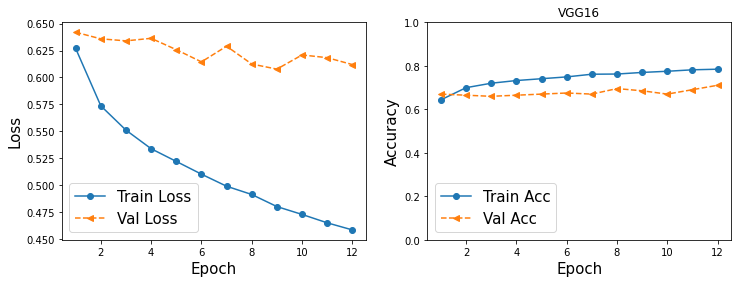

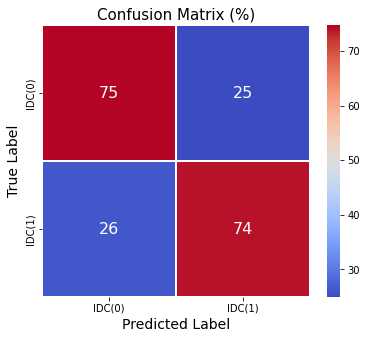

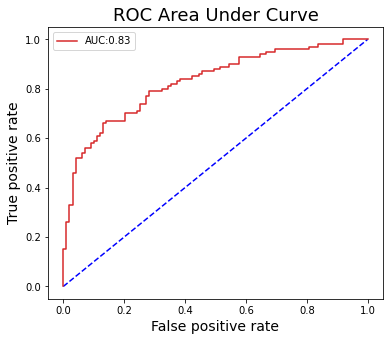

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

,TL Model,Test_Acc,Train_Acc,Val_Acc,No_Trainable_Params,Precision,Recall,F1score,ROC-AUC,ZeroOneLoss,Activation,Optimizer,LR,Brightness,Contrast,ShiftRU,ShiftLD
0,VGG16,0.74,0.78,0.71,"461,442",0.75,0.74,0.74,0.83,0.26,relu,adam,0.0001,0.3,3,"(10, -9)","(-6, 5)"


In [ ]:
chosen_model = 'VGG16'
perf_summary_vgg16 = experimenting_cnn_with_tl(chosen_model=chosen_model,
                                image_size = 50,
                                max_trials=60,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=random.choice([.2,.3,.4]),
                                contrast_factor=random.choice([2,3,4]),
                                angle=90,
                                right=random.choice([6,10,12]),
                                up=random.choice([-5,-7,-9]),
                                left=random.choice([-6,-10,-12]),
                                down=random.choice([5,7,9]))
perf_summary_vgg16

# 2) With ResNet50

INFO:tensorflow:Oracle triggered exit


Trial 30 Complete [00h 02m 33s]
val_loss: 0.5713015794754028

Best val_loss So Far: 0.5672179758548737
Total elapsed time: 01h 16m 55s
Results summary
Results in hj_dir/breast_cancer_classification
Showing 1 best trials
Trial summary
Hyperparameters:
activation: relu
optimizer: adam
dense_units_1: 896
learning_rate: 0.0001
dropout_rate_1: 0.3
dense_1: True
Score: 0.5672179758548737
None
Epoch 1/20
150/150 [==============================] - 10s 42ms/step - loss: 0.7201 - accuracy: 0.5666 - val_loss: 0.6471 - val_accuracy: 0.6345
Epoch 2/20
150/150 [==============================] - 5s 35ms/step - loss: 0.6412 - accuracy: 0.6400 - val_loss: 0.6166 - val_accuracy: 0.6904
Epoch 3/20
150/150 [==============================] - 5s 35ms/step - loss: 0.6141 - accuracy: 0.6644 - val_loss: 0.6060 - val_accuracy: 0.6853
Epoch 4/20
150/150 [==============================] - 5s 35ms/step - loss: 0.5922 - accuracy: 0.6919 - val_loss: 0.5939 - val_accuracy: 0.6954
Epoch 5/20
150/150 [=================

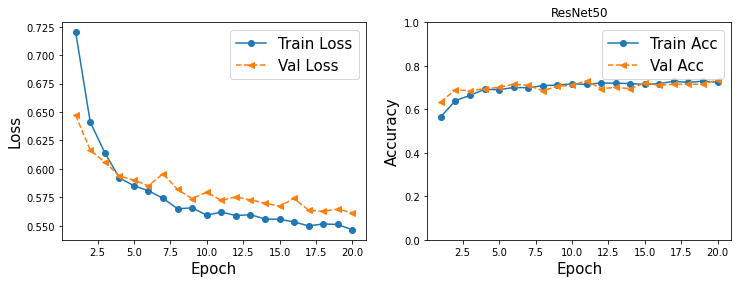

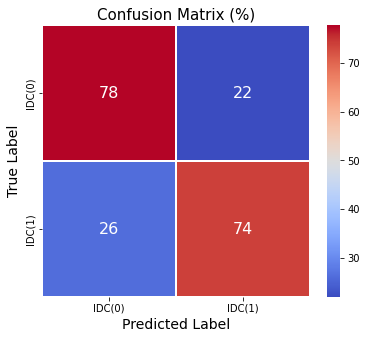

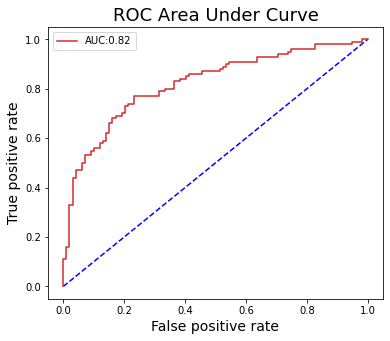

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

,TL Model,Test_Acc,Train_Acc,Val_Acc,No_Trainable_Params,Precision,Recall,F1score,ROC-AUC,ZeroOneLoss,Activation,Optimizer,LR,Brightness,Contrast,ShiftRU,ShiftLD
0,ResNet50,0.76,0.72,0.74,"7,342,722",0.77,0.74,0.75,0.82,0.24,relu,adam,0.0001,0.3,2,"(12, -5)","(-6, 5)"


In [ ]:
chosen_model = 'ResNet50'
perf_summary_resnet50 = experimenting_cnn_with_tl(chosen_model=chosen_model,
                                image_size = 50,
                                max_trials=60,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=random.choice([.2,.3,.4]),
                                contrast_factor=random.choice([2,3,4]),
                                angle=90,
                                right=random.choice([6,10,12]),
                                up=random.choice([-5,-7,-9]),
                                left=random.choice([-6,-10,-12]),
                                down=random.choice([5,7,9]))
perf_summary_resnet50

# 3) With VGG19

INFO:tensorflow:Oracle triggered exit


Trial 30 Complete [00h 00m 46s]
val_loss: 0.7939372956752777

Best val_loss So Far: 0.584586501121521
Total elapsed time: 01h 02m 23s
Results summary
Results in hj_dir/breast_cancer_classification
Showing 1 best trials
Trial summary
Hyperparameters:
activation: gelu
optimizer: adam
dense_units_1: 256
learning_rate: 0.01
dropout_rate_1: 0.2
dense_1: True
Score: 0.584586501121521
None
Epoch 1/20
150/150 [==============================] - 6s 33ms/step - loss: 0.6173 - accuracy: 0.6894 - val_loss: 0.6341 - val_accuracy: 0.6853
Epoch 2/20
150/150 [==============================] - 5s 31ms/step - loss: 0.5354 - accuracy: 0.7312 - val_loss: 0.5807 - val_accuracy: 0.7107
Epoch 3/20
150/150 [==============================] - 5s 30ms/step - loss: 0.5215 - accuracy: 0.7357 - val_loss: 0.6340 - val_accuracy: 0.6954
Epoch 4/20
150/150 [==============================] - 5s 30ms/step - loss: 0.5121 - accuracy: 0.7465 - val_loss: 0.6328 - val_accuracy: 0.7208
Epoch 5/20
150/150 [======================

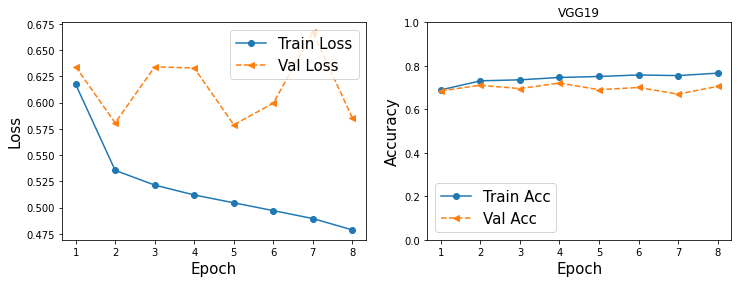

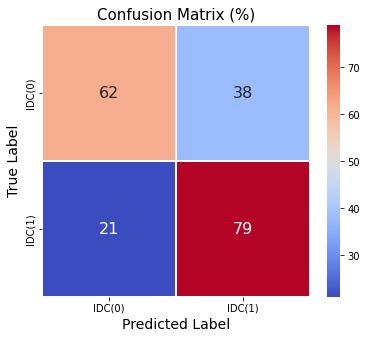

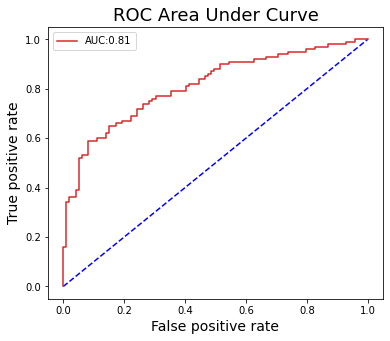

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

,TL Model,Test_Acc,Train_Acc,Val_Acc,No_Trainable_Params,Precision,Recall,F1score,ROC-AUC,ZeroOneLoss,Activation,Optimizer,LR,Brightness,Contrast,ShiftRU,ShiftLD
0,VGG19,0.7,0.77,0.71,"131,842",0.68,0.79,0.73,0.81,0.3,gelu,adam,0.01,0.2,3,"(6, -5)","(-6, 7)"


In [ ]:
chosen_model='VGG19'
perf_summary_vgg19 = experimenting_cnn_with_tl(chosen_model=chosen_model,
                                image_size = 50,
                                max_trials=60,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=random.choice([.2,.3,.4]),
                                contrast_factor=random.choice([2,3,4]),
                                angle=90,
                                right=random.choice([6,10,12]),
                                up=random.choice([-5,-7,-9]),
                                left=random.choice([-6,-10,-12]),
                                down=random.choice([5,7,9]))
perf_summary_vgg19

# 4) With DenseNet201

INFO:tensorflow:Oracle triggered exit


Trial 30 Complete [00h 06m 10s]
val_loss: 0.5851955711841583

Best val_loss So Far: 0.5642328560352325
Total elapsed time: 02h 19m 13s
Results summary
Results in hj_dir/breast_cancer_classification
Showing 1 best trials
Trial summary
Hyperparameters:
activation: leaky_relu
optimizer: adam
dense_units_1: 768
learning_rate: 0.0001
dropout_rate_1: 0.4
dense_1: True
Score: 0.5642328560352325
None
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.416634 to fit

Epoch 1/20
150/150 [==============================] - 23s 80ms/step - loss: 0.6051 - accuracy: 0.6772 - val_loss: 0.6253 - val_accuracy: 0.6650
Epoch 2/20
150/150 [==============================] - 9s 59ms/step - loss: 0.5429 - accuracy: 0.7331 - val_loss: 0.5977 - val_accuracy: 0.6904
Epoch 3/20
150/150 [==============================] - 9s 61ms/step - loss: 0.5147 - accuracy: 0.7433 - val_loss: 0.5808 - val_accuracy: 0.7005
Epoch 4/20
150/150 [==============================] - 9s 59ms/step - loss: 0.4922 - accuracy: 

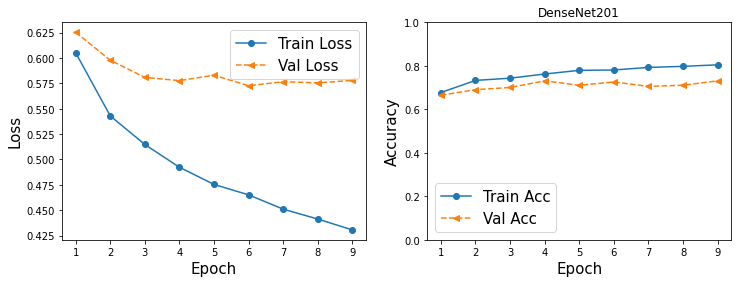

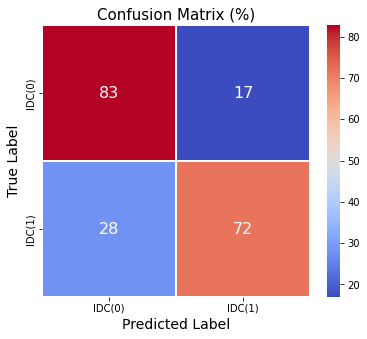

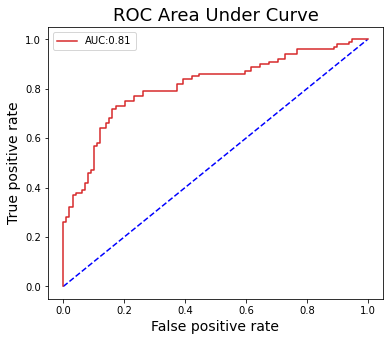

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 56, 56, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 25, 25, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

,TL Model,Test_Acc,Train_Acc,Val_Acc,No_Trainable_Params,Precision,Recall,F1score,ROC-AUC,ZeroOneLoss,Activation,Optimizer,LR,Brightness,Contrast,ShiftRU,ShiftLD
0,DenseNet201,0.77,0.8,0.73,"1,476,866",0.81,0.72,0.76,0.81,0.23,leaky_relu,adam,0.0001,0.2,4,"(6, -5)","(-10, 5)"


In [ ]:
chosen_model='DenseNet201'
perf_summary_densenet201 = experimenting_cnn_with_tl(chosen_model=chosen_model,
                                image_size = 50,
                                max_trials=60,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=random.choice([.2,.3,.4]),
                                contrast_factor=random.choice([2,3,4]),
                                angle=90,
                                right=random.choice([6,10,12]),
                                up=random.choice([-5,-7,-9]),
                                left=random.choice([-6,-10,-12]),
                                down=random.choice([5,7,9]))
perf_summary_densenet201

# 5) ResNet152V2

INFO:tensorflow:Oracle triggered exit


Trial 30 Complete [00h 02m 08s]
val_loss: 0.6010764241218567

Best val_loss So Far: 0.582158237695694
Total elapsed time: 01h 45m 53s
Results summary
Results in hj_dir/breast_cancer_classification
Showing 1 best trials
Trial summary
Hyperparameters:
activation: gelu
optimizer: adam
dense_units_1: 640
learning_rate: 0.0001
dropout_rate_1: 0.2
dense_1: False
Score: 0.582158237695694
None
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.529046 to fit

Epoch 1/20
150/150 [==============================] - 21s 83ms/step - loss: 0.7336 - accuracy: 0.6043 - val_loss: 0.5962 - val_accuracy: 0.6802
Epoch 2/20
150/150 [==============================] - 10s 68ms/step - loss: 0.6339 - accuracy: 0.6763 - val_loss: 0.5859 - val_accuracy: 0.6802
Epoch 3/20
150/150 [==============================] - 11s 77ms/step - loss: 0.5881 - accuracy: 0.7068 - val_loss: 0.5804 - val_accuracy: 0.7056
Epoch 4/20
150/150 [==============================] - 11s 70ms/step - loss: 0.5594 - accuracy: 0.72

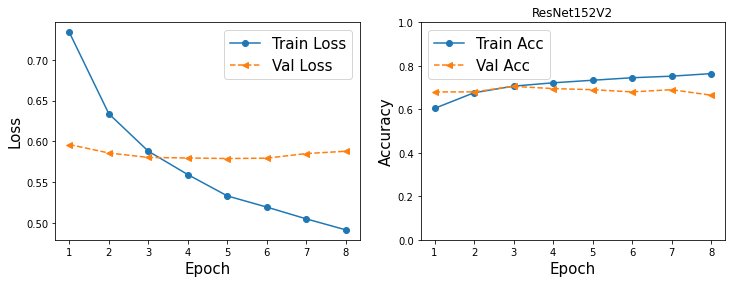

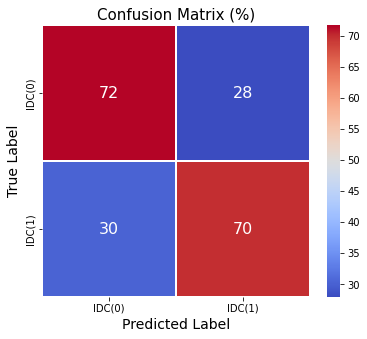

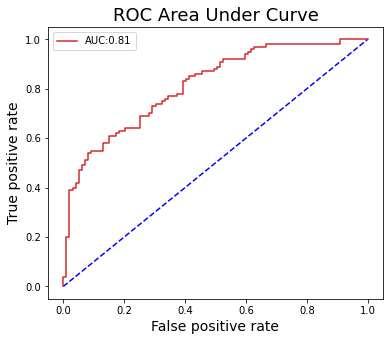

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 27, 27, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

,TL Model,Test_Acc,Train_Acc,Val_Acc,No_Trainable_Params,Precision,Recall,F1score,ROC-AUC,ZeroOneLoss,Activation,Optimizer,LR,Brightness,Contrast,ShiftRU,ShiftLD
0,ResNet152V2,0.71,0.76,0.66,"16,386",0.71,0.7,0.7,0.81,0.29,gelu,adam,0.0001,0.3,2,"(10, -9)","(-12, 9)"


In [ ]:
chosen_model='ResNet152V2'
perf_summary_resnet152v2 = experimenting_cnn_with_tl(chosen_model=chosen_model,
                                image_size = 50,
                                max_trials=60,
                                batch_size=64,
                                epochs=20,
                                brightness_delta=random.choice([.2,.3,.4]),
                                contrast_factor=random.choice([2,3,4]),
                                angle=90,
                                right=random.choice([6,10,12]),
                                up=random.choice([-5,-7,-9]),
                                left=random.choice([-6,-10,-12]),
                                down=random.choice([5,7,9]))
perf_summary_resnet152v2